# Import Module

In [107]:
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, ProjectedGradientDescentPyTorch
from art.metrics import empirical_robustness
import timeit
from art.estimators.classification import PyTorchClassifier
import numpy as np
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.nn.functional import nll_loss
from torchvision import transforms, datasets
from torch import optim
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
from torch.autograd import Variable
from art.metrics import wasserstein_distance

%matplotlib inline

# Preprocessing Data Load

In [3]:
trans = transforms.Compose([transforms.Resize((150,150)),
                            transforms.ToTensor(),
                            transforms.Grayscale(num_output_channels=1)
                            ])
dataset = datasets.ImageFolder(root = './preprocessing/', transform = trans)

train_dataset, test_dataset  = random_split(dataset, [130,34])

# Convert Dataset To Array

In [5]:
def datasetToArr(dataset):
    x_new = np.array([])
    y_new = np.array([])
    for data in dataset:
        if x_new.size == 0:
            x_new = np.array(data[0].unsqueeze(0))
        else:
            x_new = np.concatenate((x_new, np.array(data[0].unsqueeze(0))), axis=0)
        y_new = np.append(y_new, data[1])

    return x_new, y_new

In [28]:
x_test_new, y_test_new = datasetToArr(test_dataset)
x_train_new, y_train_new = datasetToArr(train_dataset)
x_all, y_all = datasetToArr(dataset)

# Model

In [7]:
def get_output_size(network):
    if type(network) != list:
        network = [network]
        
    output = Variable(torch.ones(1, 1, 150, 150))
    for conv in network:
        output = conv.forward(output)
    
    # return np.asscalar(np.prod(output.data.shape)), output.data.size()[2]
    return np.prod(output.data.shape)


class ConvLayer(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=5, max_pool_stride=2):
        super(ConvLayer, self).__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=kernel_size)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=max_pool_stride)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv2(self.relu(self.conv1(x))))
        return self.max_pool2d(x)


class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convs = []
        self.convs.append(ConvLayer(1, 32, kernel_size=5))
        self.convs.append(ConvLayer(32, 64, kernel_size=5))
        conv_output_size = get_output_size(self.convs)
        self.fully_connected1 = nn.Linear(conv_output_size, 1024)
        self.fully_connected2 = nn.Linear(1024, 15)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fully_connected1(x))
        return nn.functional.log_softmax(self.fully_connected2(x))

# Declare Original Model and Classifier

In [125]:
model = torch.load('./model.pt')

classifier = PyTorchClassifier(model=model,
                                    nb_classes=15,
                                    clip_values=(0.0, 1.0),
                                    input_shape=tuple(train_dataset[0][0].shape[1:]),
                                    loss=torch.nn.CrossEntropyLoss())

# Define Function of Predict Accuracy

In [32]:
def accuracyOnPredict(predictions):
    correct = 0
    index = 0
    for predict in predictions:
        pred = np.argmax(predict)
        if pred == y_test_new[index]:
            correct += 1

        index += 1

    return correct/len(y_test_new)

# Impact of eps & norm - FGM

In [ ]:
FGM_eps_list = [0.1, 0.15, 0.17, 0.2, 0.23, 0.26, 0.3]
norm_list = ["inf", 1, 2]
FGM_datasets = []

for norm_elem in norm_list:
    print("\n--------------"+str(norm_elem)+"--------------")
    for eps_elem in eps_list:
        PGD_PyTorch = ProjectedGradientDescentPyTorch(classifier, norm = 'inf',
                        eps=eps_elem, eps_step=0.01, targeted=False,
                        max_iter=10,
                        num_random_init=5,
                        batch_size=16,
                        )

    start = timeit.default_timer()
    FGM_test_adv = FGM_PyTorch.generate(x_test_new)
    stop = timeit.default_timer()
    
    print('Time: ', stop - start)

    FGM_datasets.append(FGM_test_adv)

    FGM_predictions = classifier.predict(FGM_test_adv)

    print("FGM_"+ str(eps_elem) +" Accuracy : " + str(accuracyOnPredict(FGM_predictions)))

# Impact of eps & max_iter - BIM

In [ ]:
BIM_eps_list = [0.1, 0.15, 0.17, 0.2, 0.23, 0.26, 0.3]
max_iter_list = [10, 20, 30]
BIM_datasets = []

for iter_elem in max_iter_list:
    print("\n--------------"+str(iter_elem)+"--------------")
    for eps_elem in eps_list:
        BIM = BasicIterativeMethod(classifier,
                        eps=eps_elem, eps_step=0.01, targeted=False,
                        max_iter=iter_elem,
                        batch_size=16,
                        verbose=False
                        )

    start = timeit.default_timer()
    BIM_test_adv = BIM.generate(x_test_new)
    stop = timeit.default_timer()
    
    print('Time: ', stop - start)

    BIM_datasets.append(BIM_test_adv)

    BIM_predictions = classifier.predict(BIM_test_adv)

    print("BIM_"+ str(eps_elem) +" Accuracy : " + str(accuracyOnPredict(BIM_predictions)))

# Impact of eps - PGD

In [113]:
PGD_eps_list = [0.1, 0.15, 0.17, 0.2, 0.23, 0.26, 0.3]
PGD_datasets = []

for eps_elem in eps_list:
    PGD_PyTorch = ProjectedGradientDescentPyTorch(classifier, norm = 'inf',
                    eps=eps_elem, eps_step=0.01, targeted=False,
                    max_iter=10,
                    num_random_init=5,
                    batch_size=16,
                    )

    start = timeit.default_timer()
    PGD_test_adv = PGD_PyTorch.generate(x_test_new)
    stop = timeit.default_timer()
    
    print('Time: ', stop - start)

    PGD_datasets.append(PGD_test_adv)

    PGD_predictions = classifier.predict(PGD_test_adv)

    print("PGD_"+ str(eps_elem) +" Accuracy : " + str(accuracyOnPredict(PGD_predictions)))

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_11494/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


PGD - Batches:   0%|          | 0/2 [00:00<?, ?it/s]

PGD_0.2 Accuracy : 0.2647058823529412


PGD - Batches:   0%|          | 0/2 [00:00<?, ?it/s]

PGD_0.23 Accuracy : 0.20588235294117646


PGD - Batches:   0%|          | 0/2 [00:00<?, ?it/s]

PGD_0.26 Accuracy : 0.14705882352941177


PGD - Batches:   0%|          | 0/2 [00:00<?, ?it/s]

PGD_0.3 Accuracy : 0.11764705882352941


# Show Adversarial Image

In [137]:
def show_adversarial_image(eps_list, datasets):
    fig = plt.figure(figsize=(10,10))
    index = 1
    for eps_index in range(0,len(eps_list)):
        image = Image.fromarray((datasets[eps_index][0]*255).astype(np.uint8).squeeze())
        image = image.convert('L')
        ax1 = fig.add_subplot(len(eps_list), 1, index)
        ax1.imshow(np.array(image), cmap='gray')
        ax1.set_xlabel(str(eps_list[index-1]))
        ax1.set_xticks([]), ax1.set_yticks([])
        index = index+1

    plt.show()

In [ ]:
show_adversarial_image(FGM_eps_list, FGM_datasets)

In [ ]:
show_adversarial_image(BIM_eps_list, BIM_datasets)

In [ ]:
show_adversarial_image(PGD_eps_list, PGD_datasets)

# Check Empirical Robustness of FGSM

In [127]:
empirical_robustness(classifier,
                      x=x_test_new,
                      attack_name='fgsm',
                     attack_params={'norm':np.inf}
                     )

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_11494/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


0.18697523

# Create Each Adversarial Image with Optimum parameters

## FGM

In [128]:
FGM = FastGradientMethod(classifier, norm = "inf", 
                        eps=0.2, eps_step=0.01, targeted=False,
                        num_random_init=0,
                        batch_size=16,
                        minimal=True)

start = timeit.default_timer()
FGM_test_adv = FGM.generate(x_test_new)
stop = timeit.default_timer()

print('Time: ', stop - start)

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_11494/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


Time:  35.704074324999965


## BIM

In [129]:
BIM = BasicIterativeMethod(classifier,
                        eps=0.2, eps_step=0.01, targeted=False,
                        max_iter=10,
                        batch_size=16,
                        verbose=False
                        )

start = timeit.default_timer()
BIM_test_adv = BIM.generate(x_test_new)
stop = timeit.default_timer()

print('Time: ', stop - start)

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_11494/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


Time:  62.26178963100028


## PGD

In [130]:
PGD_PyTorch = ProjectedGradientDescentPyTorch(classifier, norm = "inf", 
                        eps=0.3, eps_step=0.01, targeted=False,
                        max_iter=10,
                        num_random_init=5,
                        batch_size=16,
                        )

start = timeit.default_timer()
PGD_test_adv = PGD_PyTorch.generate(x_test_new)
stop = timeit.default_timer()

print('Time: ', stop - start)

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_11494/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


PGD - Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Time:  313.9506145069972


# Check Degree of Modification

In [131]:
FGM_wd = wasserstein_distance(x_test_new, FGM_test_adv)
BIM_wd = wasserstein_distance(x_test_new, BIM_test_adv)
PGD_wd = wasserstein_distance(x_test_new, PGD_test_adv)

print(np.sum(FGM_wd), np.sum(BIM_wd), np.sum(PGD_wd))

2.0342607479255026 0.8217294678227149 2.234753785459056


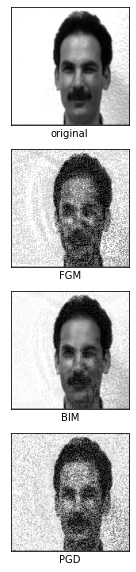

In [138]:
show_adversarial_image(['original', 'FGM', 'BIM', 'PGD'], [x_test_new[0], FGM_test_adv[0], BIM_test_adv[0], PGD_test_adv[0]])

# Generate PGD Adversarial Train Dataset

In [ ]:
start = timeit.default_timer()
PGD_train_adv = PGD_PyTorch.generate(x_train_new)
stop = timeit.default_timer()

# Declare Attack Model and Parameters

In [ ]:
batch_size = 16
epochs = 50

tensorX = torch.tensor(PGD_train_adv)
tensorY = torch.tensor(y_train_new)
tensorY = tensorY.long()
dataset_train_PGD = TensorDataset(tensorX, tensorY)
attack_train_loader = DataLoader(dataset_train_PGD,
                         batch_size = batch_size, shuffle=False)

attack_model = Network()
optimizer=optim.Adam(attack_model.parameters(), lr=0.001)

In [ ]:
def train(model, optimizer, train_loader):
    model.train()
    train_result={'epoch':[], 'loss':[]}

    for i in range(epochs):
        loss_data=[]
        for images, labels in train_loader:
            running_time=0

            images, labels = Variable(images), Variable(labels)

            optimizer.zero_grad()

            output = model(images)

            loss = nll_loss(output, labels)
            loss.backward()
            optimizer.step()
            loss_data.append(loss.data)

        print('Train Epoch: {} \tLoss: {:.6f}'.format(i, np.mean(loss_data)))

# Train Model with PGD Adversarial Dataset

In [ ]:
train(attack_model, optimizer, attack_train_loader)

In [ ]:
torch.save(attack_model, './PGD_model.pt')

# Check Accuracy of Original Model

In [139]:
ORIGIN_predictions = classifier.predict(x_test_new)
FGM_predictions = classifier.predict(FGM_test_adv)
BIM_predictions = classifier.predict(BIM_test_adv)
PGD_predictions = classifier.predict(PGD_test_adv)

print("ORIGINAL Accuracy in Original Model : " + str(accuracyOnPredict(ORIGIN_predictions)))
print("FGM Accuracy in Original Model : " + str(accuracyOnPredict(FGM_predictions)))
print("BIM Accuracy in Original Model : " + str(accuracyOnPredict(BIM_predictions)))
print("PGD Accuracy in Original Model : " + str(accuracyOnPredict(PGD_predictions)))

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_11494/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


ORIGINAL Accuracy in Original Model : 0.9411764705882353
FGM Accuracy in Original Model : 0.38235294117647056
BIM Accuracy in Original Model : 0.6176470588235294
PGD Accuracy in Original Model : 0.08823529411764706


# Check Accuracy of PGD Model

In [140]:
PGD_model = torch.load('./PGD_model.pt')

classifier_PGD = PyTorchClassifier(model=PGD_model,
                                    nb_classes=15,
                                    clip_values=(0.0, 1.0),
                                    input_shape=tuple(train_dataset[0][0].shape[1:]),
                                    loss=torch.nn.CrossEntropyLoss())

In [146]:
ORIGIN_predictions_PGD = classifier_PGD.predict(x_test_new)
FGM_predictions_PGD = classifier_PGD.predict(FGM_test_adv)
BIM_predictions_PGD = classifier_PGD.predict(BIM_test_adv)
PGD_predictions_PGD = classifier_PGD.predict(PGD_test_adv)

print("ORIGIN Accuracy in PGD Attack Model: " + str(accuracyOnPredict(ORIGIN_predictions_PGD)))
print("FGM Accuracy in PGD Attack Model: " + str(accuracyOnPredict(FGM_predictions_PGD)))
print("BIM Accuracy in PGD Attack Model: " + str(accuracyOnPredict(BIM_predictions_PGD)))
print("PGD Accuracy in PGD Attack Model: " + str(accuracyOnPredict(PGD_predictions_PGD)))

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_11494/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


ORIGIN Accuracy in PGD Attack Model: 0.8529411764705882
FGM Accuracy in PGD Attack Model: 0.9411764705882353
BIM Accuracy in PGD Attack Model: 0.9411764705882353
PGD Accuracy in PGD Attack Model: 0.9705882352941176


# Check Accuracy of FGM Model

In [144]:
FGM_model = torch.load('./FGM_model.pt')

classifier_FGM = PyTorchClassifier(model=FGM_model,
                                    nb_classes=15,
                                    clip_values=(0.0, 1.0),
                                    input_shape=tuple(train_dataset[0][0].shape[1:]),
                                    loss=torch.nn.CrossEntropyLoss())

In [145]:
ORIGIN_predictions_FGM = classifier_FGM.predict(x_test_new)
FGM_predictions_FGM = classifier_FGM.predict(FGM_test_adv)
BIM_predictions_FGM = classifier_FGM.predict(BIM_test_adv)
PGD_predictions_FGM = classifier_FGM.predict(PGD_test_adv)

print("ORIGIN Accuracy in FGM Attack Model: " + str(accuracyOnPredict(ORIGIN_predictions_FGM)))
print("FGM Accuracy in FGM Attack Model: " + str(accuracyOnPredict(FGM_predictions_FGM)))
print("BIM Accuracy in FGM Attack Model: " + str(accuracyOnPredict(BIM_predictions_FGM)))
print("PGD Accuracy in FGM Attack Model: " + str(accuracyOnPredict(PGD_predictions_FGM)))

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_11494/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


ORIGIN Accuracy in FGM Attack Model: 0.9411764705882353
FGM Accuracy in FGM Attack Model: 0.9411764705882353
BIM Accuracy in FGM Attack Model: 0.9411764705882353
PGD Accuracy in FGM Attack Model: 0.8529411764705882
